# Testing Notebook
Notebook for testing the constraints.jl code

## Load constraints

In [16]:
include("constraints.jl")

plotConstraint (generic function with 1 method)

## Define plotting functions

In [13]:
function plotConstraints(adm::ADM)
    #adm = ADM(rM=1e-2,m=5.11,dα=0.01)
    #fig,h1 = plotConstraint(getLSSProperties,ADM(),name="LSS SM")
    #display(adm)
    fig,hlss = plotConstraint(getLSSProperties,adm,name="LSS")
    _,hms = plotConstraint(getDwGalProperties,adm,fig=fig,name="Miss Sat")
    _,hdb = plotConstraint(getDBCProperties,adm,fig=fig,name="DBC")
    _,hdco = plotConstraint(getDCOProperties,adm,fig=fig,name="\$10^6-10^9\$ Halos Cool",ctype=strucform)
    _,hmw = plotConstraint(getMWProperties,adm,fig=fig,name="MW no cool",ctype=strucform)
    println("Plotted Constraints")
    handles = [hlss[1],hms[1],hdb[1],hdco[1],hmw[1]]
    T = 10 .^ range(-2,10,length=50)
    zBH=5
    nBH = nofz(adm.M,zBH)
    nBH = 1
    println("nBH:$nBH")
    ΛSM = get_Lambda.(nBH,T)
    #println("Post SM")
    ΛP = get_Lambda.(nBH,T;adm)
    #push!(handles,loglog(T,ΛSM,linestyle="dashdot",label="SM")[1]) # loglog returns a 1 element list
    push!(handles,loglog(T,ΛP,linestyle="solid",label="M=$(adm.M) GeV m=$(adm.m) keV")[1])
    legend(;handles)
    title("M:$(adm.M) GeV m:$(adm.m) keV α\$_D\$:$(adm.dα)")
end

function plotExamplePoints()
    # Example points are SM values and (14 Gev, 325 keV, 0.01) from the paper
    rα = [1, 0.01/ADM().α]
    r_m = [1, 325/ADM().m]
    r_M = [1, 14/ADM().M]
    ratom = rα.^2 .* r_m
    rrot = rα.^2 .* r_m.^2 ./ r_M
    
    PyPlot.plot(ratom[1],rrot[1],"*",label="SM")
    PyPlot.plot(ratom[2],rrot[2],"*",label="Paper")
    
end

plotExamplePoints (generic function with 1 method)

## Testing constraints plots
The first plot should match the plot from [2009.05209](https://arxiv.org/abs/2009.05209) with the addition of the DBC and MW constraints and molecular cooling.

The second plot shows constraint situation if SM values are used instead

Plotted Constraints
nBH:1


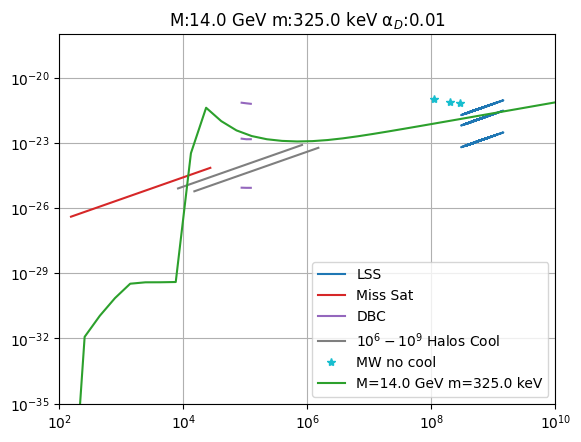

(100.0, 1.0e10)

In [17]:
adm = ADM(M=14,m=325,dα=0.01)
plotConstraints(adm)
PyPlot.xlim(1e2,1e10)

Plotted Constraints
nBH:1


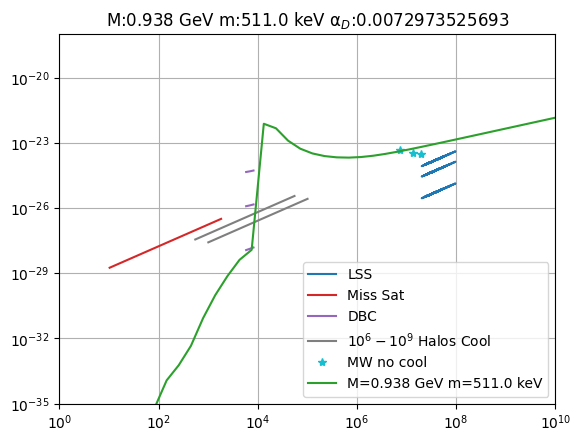

PyObject Text(0.5, 1.0, 'M:0.938 GeV m:511.0 keV α$_D$:0.0072973525693')

In [18]:
adm = ADM()
plotConstraints(adm)

## Example checkAllConstraints output
Here we show the output of the checkAllConstraints function for the two cases above. 

We should see one true each for LSS and DBC, 2 for DCO, and 3 for MW for the paper, and all the rest false.

For SM values, we should see two true for DBC, two true for DCO, one true for MW and all the rest false.

In [23]:
adm = ADM(M=14,m=325,dα=0.01)
checksDM = checkAllConstraints(get_Lambda,adm;n_test=1)
print("Paper values:\t")
display(checksDM)
isgood = (count(checksDM["DwG"])==0 && count(checksDM["LSS"])==1 && count(checksDM["DBC"])==1 
    && count(checksDM["DCO"])==2 && count(checksDM["MWG"])==3 ? "passed" : "failed")
println("Check: $(isgood)")
adm = ADM()
checksSM = checkAllConstraints(get_Lambda,adm;n_test=1)
print("SM values:\t")
display(checksSM)
isgood = (count(checksSM["DwG"])==0 && count(checksSM["LSS"])==0 && count(checksSM["DBC"])==2 
    && count(checksDM["DCO"])==2 && count(checksDM["MWG"])==1 ? "passed" : "failed")
println("Check: $(isgood)")

Paper values:	

Dict{Any, Any} with 5 entries:
  "DCO" => Any[true, true]
  "DwG" => Any[false]
  "LSS" => Any[false, false, true]
  "DBC" => Any[false, false, true]
  "MWG" => Any[true, true, true]

Check: passed
SM values:	

Dict{Any, Any} with 5 entries:
  "DCO" => Any[true, true]
  "DwG" => Any[false]
  "LSS" => Any[false, false, false]
  "DBC" => Any[false, true, true]
  "MWG" => Any[true, false, false]

Check: failed


# Plotting in ADM space
We want to plot which constraints are violated as a function of atomic binding energy vs rotational binding energy. That necessitates a fixed $\alpha=0.01$, $\xi=0.0005$, and $\epsilon=1$ for now. James' DAO constraints will probably include multiple $\xi$ values at the least

## Generate check grids
checks is a dictionary, where each key represents a constraint (must match the list of keys returned by checkAllConstraints) and the corresponding value is the number of times the constraint holds divided by the total number of possibilities. For example, the LSS constraint tests whether $\Lambda_{test}$ < $\Lambda_{LSS}$ over a range of $M_{halo}\rightarrow T$ for 3 given values of `f_lost` (alternatively, `plotConstraint` for LSS plots three lines). Then for a given ADM point, `checks["LSS"][adm]` will be equal to the (number of lines satisfied by $\Lambda_{ADM}$) $/ 3$. From the figures above, the $\{14,325,0.01\}$ point would be $1/3$, while the SM point would be 0. So for a given point, a really strong constraint would approach 0, and a really weak constraint would approach 1. This definition may switch in the future.

In [24]:
using LazyGrids
# make the binding energy grids. It's probably more interesting to plot vs binding energy scaling, so that's what we'll do
dα = 0.01
adm = ADM(;ξ=0.0005,dα)
rα = adm.rα

# Sampling in rm,rM space
# r_m = 10 .^ range(-2,2,length=10) # the name rm is used by Filesystem
# r_M = 10 .^ range(-2,3,length=10)
# r_m, r_M = ndgrid(r_m, r_M)
# ratom = adm.rα^2 .* r_m
# rrot = adm.rα^2 .* r_m.^2 ./ r_M

# Sampling in rATOM=rA, rROT=rR space
rA = 10 .^ range(-2,2,length=40)
rR = 10 .^ range(-2,2, length=40)
rA, rR = ndgrid(rA, rR)
r_m = rA ./ rα^2
r_M = rA .^2 ./ (rα^2 .* rR)
rV = rA .* sqrt.(rR ./ rA);

Run grids. Since this is slow, we'll save the checks object so we don't have to run the grids computation each time. If you need to rerun for some reason, either set force to true or delete the `checks.jld2` file

In [25]:
using ProgressMeter
using JLD2
using UnPack

force = false
if !isfile("checks.jld2") || force

checks = Dict("DwG"=>similar(rA),"LSS"=>similar(rA),"DBC"=>similar(rA))
n = length(eachindex(rA))
p = Progress(n, dt=0.5,
             barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
             barlen=10,
             showspeed=true)
for ind = eachindex(rA)
    set_m!(adm,rm=r_m[ind])
    set_M!(adm,rM=r_M[ind])
    #continue
    check = checkAllConstraints(get_Lambda,adm;n_test=1)
    for k in keys(checks)
        checks[k][ind] = count(check[k])/size(check[k])[1]
    end
    next!(p)
end

    JLD2.jldopen("checks.jld2","w") do file
        @pack! file = adm,r_m,r_M,rA,rR,rV,checks
    end
else
    JLD2.jldopen("checks.jld2","r") do file
        @unpack adm,r_m,r_M,rA,rR,rV,checks = file
    end
end

┌ Warning: type Main./home/strato/workspace/Research/projects/constraints/Get_Lambda.jl.Get_Lambda.ADM does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495


JLDFile /home/strato/workspace/Research/projects/constraints/checks.jld2 (read-only)
  (closed)

## Plot Check grids

In [26]:
using PyPlot

fig = figure()
x = rA
y = rR
cols = Dict("LSS"=>"Greens","DwG"=>"Blues","DBC"=>"Reds")
hat = Dict("LSS"=>"/","DwG"=>"-","DBC"=>"o")
alpha_offset = 0.2
for k in keys(checks)
    #contour(x,y,checks[k],levels=2,label=k)
    #masked = convert(Matrix{Union{Float64,Missing}},checks[k])
    # matplotlib uses NaNs to mask data apparently
    masked = 1.0 .- copy(checks[k])
    masked[masked .== 0.0] .= NaN
    pcolormesh(x,y, masked,cmap=cols[k],alpha=.5+alpha_offset,)
    alpha_offset -= 0.1
    clim(0,1)
end
PyPlot.xlim(extrema(x))
PyPlot.ylim(extrema(y))
PyPlot.xscale("log")
PyPlot.yscale("log")
PyPlot.xlabel("r\$_{\\rm Atom}\$")
PyPlot.ylabel("r\$_{\\rm Rotational}\$")
plotExamplePoints()
title("Shaded region is not allowed")

LoadError: UndefVarError: `checks` not defined

In [9]:
using PyPlot

fig = figure()
x = rA
y = rR
k = "DwG"
masked = 1 .- copy(checks[k])
masked[masked.==0.0] .= NaN
pcolormesh(x,y,masked,label=k,cmap=cols[k],alpha=0.8,edgecolor="none")
PyPlot.xlim(extrema(x))
PyPlot.ylim(extrema(y))
PyPlot.xscale("log")
PyPlot.yscale("log")
plotExamplePoints()
PyPlot.colorbar()
PyPlot.clim(0,1)

LoadError: UndefVarError: `checks` not defined